In [22]:
import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image

In [2]:
## extracting the zipfile
with zipfile.ZipFile("dc100.zip",'r') as zip_ref:
  zip_ref.extractall()

In [3]:
## Making a generater
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [8]:
## Declear a function which takes an input dictionary and a new output file location and returns some augmentated images
def data_aug(image_path,new_path,num_image=5):
  for filename in os.listdir(image_path):
    if filename.endswith('.jpg'):
      path = os.path.join(image_path,filename)
      image = Image.open(path)
      image = image.resize((128,128))
      image = np.array(image)/255
      image = np.expand_dims(image,axis=0) ## Adds extra dimension
      i=0
      for batch in datagen.flow(image,batch_size=1,save_to_dir=new_path,save_prefix=filename,save_format='jpeg'):
        i+=1
        if i>num_image:
          break

In [10]:
# Making a function to read all the augmented/any images and return 2 arrays of image and label
def read_images(image_path):
  images = []
  labels = []
  for filename in os.listdir(image_path):
    if filename.endswith('.jpeg'):
      path = os.path.join(image_path,filename)
      image = Image.open(path)
      image = image.resize((128,128))
      image = np.array(image)/255
      images.append(image)
      if 'dog' in filename:
        labels.append(1)
      else:
        labels.append(0)
  return np.array(images),np.array(labels)

In [9]:
data_aug('dc100','datagen',5) ## Applying the data augmentation function

In [11]:
X,Y = read_images('datagen') ## Appplying the image reading function

In [12]:
print(X.shape)
print(Y.shape)

(1200, 128, 128, 3)
(1200,)


In [13]:
## Import the nessecery libraries for modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten,BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [14]:
base_model = VGG16(weights='imagenet',include_top=False,input_shape=((128,128,3))) ## Load the base layer (VGG16)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
## Make all the base layers of VGG16 freeze
for layer in base_model.layers:
  layer.trainable = False
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [16]:
## Make a sequential model taking the base as the VGG16
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')
])

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics = ['accuracy']) ## Compile the model

In [18]:
## Make a function to print the loss on a particular epoch
from tensorflow.keras.callbacks import Callback
class PrintLoss(Callback):
  def on_epoch_end(self,epoch,logs=None):
    if (epoch+1)%2==0 or epoch==0:
      print(f"Epoch {epoch+1} loss: {logs['loss']}")

In [19]:
history=model.fit(X,Y,batch_size=24,epochs=10,validation_split=0.2,verbose=0,callbacks=[PrintLoss()]) ## Fit the model with the data

Epoch 1 loss: 0.6329495906829834
Epoch 2 loss: 0.45044460892677307
Epoch 4 loss: 0.33355700969696045
Epoch 6 loss: 0.23931393027305603
Epoch 8 loss: 0.19928370416164398
Epoch 10 loss: 0.16113758087158203


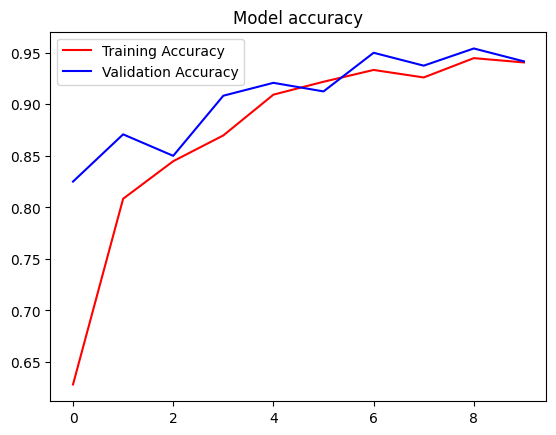

In [20]:
## Plot the accuracy of the Train and validation data
plt.plot(history.history['accuracy'],c='r',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],c='b',label='Validation Accuracy')
plt.legend()
plt.title('Model accuracy')
plt.show()

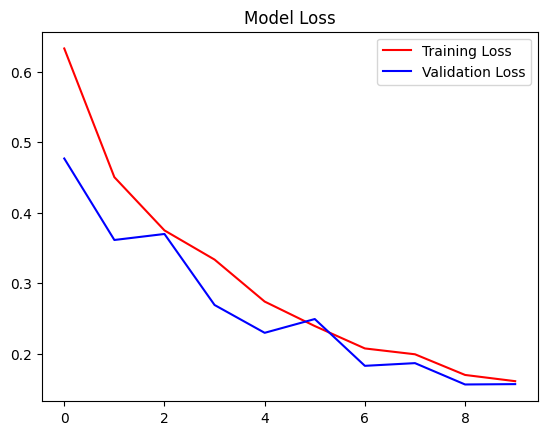

In [21]:
## Print the loss of Train and the validation data
plt.plot(history.history['loss'],c='r',label='Training Loss')
plt.plot(history.history['val_loss'],c='b',label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

In [29]:
## Making a function to simplify the prediction for a single image
def img_pred(img_path):
  img = image.load_img(img_path, target_size=(128,128))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = img_array / 255.0
  prediction = model.predict(img_array,verbose=0)
  if prediction[0][0] > 0.5:
    print("\033[1mThis is a Dog\n")
  else:
    print("\033[1mThis is a Cat\n")
  img=Image.open(img_path)
  img=img.resize((128,128))
  return img

This is a Cat



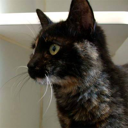

In [39]:
img_pred('5.jpg')